# Transpile your QAOA circuit with `qiskit` and `qopt-best-practices`

In [1]:
# Uncomment and run this cell to install requirements for the notebook

# !pip install qopt-best-practices@git+https://github.com/qiskit-community/qopt-best-practices@1b92b695848ea0ecedbbc3ddb98769137e91e7d9
# !pip install matplotlib
# !pip install pylatexenc

This notebook contains practical examples of how to apply different transpilation strategies on QAOA circuits.

<img src="images/transpile.png" width="1200">

For more in-depth tutorials, check out the qopt-best-practices how-to section.

**Note**: cells marked as "SETUP" are not shown in the accompanying presentation

## 1. How to apply SWAP strategies for routing

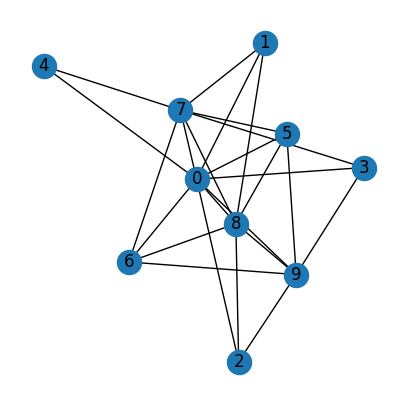

In [2]:
# SETUP: build graph, get cost op, define coupling map and backend

import matplotlib.pyplot as plt
import networkx as nx

# graph = nx.random_regular_graph(n=20, d=3, seed=0)
graph = nx.barabasi_albert_graph(n=10, m=6, seed=42)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

from qiskit.quantum_info import SparsePauliOp
from qopt_best_practices.utils import build_max_cut_paulis

cost_operator = SparsePauliOp.from_list(build_max_cut_paulis(graph))

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap([(idx, idx + 1) for idx in range(graph.order() - 1)])
backend = GenericBackendV2(
    num_qubits=10,
    coupling_map=cmap,
    basis_gates=["x", "sx", "rzz", "id", "rz"],
    seed=0,
)

nx.draw(graph, with_labels=True, ax=ax)

### 1.1. Define cost layer

In [3]:
from qiskit import QuantumCircuit
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

dummy_mixer_operator = SparsePauliOp.from_list(
    [("I" * cost_operator.num_qubits, 1)]
)  # An empty mixer

cost_layer = annotated_qaoa_ansatz(
    cost_operator,
    reps=1,
    initial_state=QuantumCircuit(cost_operator.num_qubits),  # An empty initial state
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

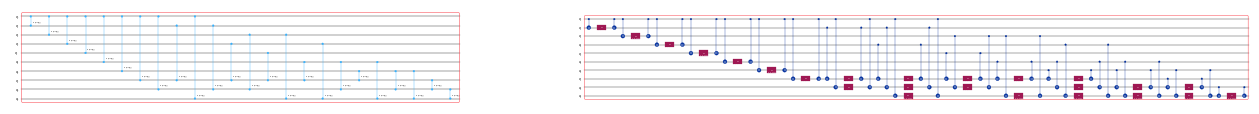

In [4]:
# SETUP: draw cost layer

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1.5]})

cost_layer.draw("mpl", ax=axs[0], fold=False)
cost_layer.decompose(reps=3).draw("mpl", ax=axs[1], fold=False)

### 1.2. Define swap strategy and edge coloring

In [5]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
)

swap_strategy = SwapStrategy.from_line([i for i in range(cost_operator.num_qubits)])
edge_coloring = {(idx, idx + 1): (idx) % 2 for idx in range(cost_operator.num_qubits)}

In [6]:
print(swap_strategy)
print("---")
print(edge_coloring)

SwapStrategy with swap layers:
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
on [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [9, 8]] coupling map.
---
{(0, 1): 0, (1, 2): 1, (2, 3): 0, (3, 4): 1, (4, 5): 0, (5, 6): 1, (6, 7): 0, (7, 8): 1, (8, 9): 0, (9, 10): 1}


### 1.3. Define custom routing pass managers and run

In [7]:
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation import (
    AnnotatedPrepareCostLayer,
    AnnotatedCommuting2qGateRouter,
    SynthesizeAndSimplifyCostLayer,
    UnrollBoxes,
)

# Let's route the QAOA circuit to a line of qubits using the swap strategy.
pm1 = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
    ]
)
qc1 = pm1.run(cost_layer)

# Let's synthesize the circuit into Rzs and CNOTs and cancel any
# double CNOTs that compose to the identity.
pm2 = PassManager(
    [
        SynthesizeAndSimplifyCostLayer(basis_gates=["x", "cx", "sx", "rz", "id"]),
        UnrollBoxes(),
    ]
)
qc2 = pm2.run(qc1)

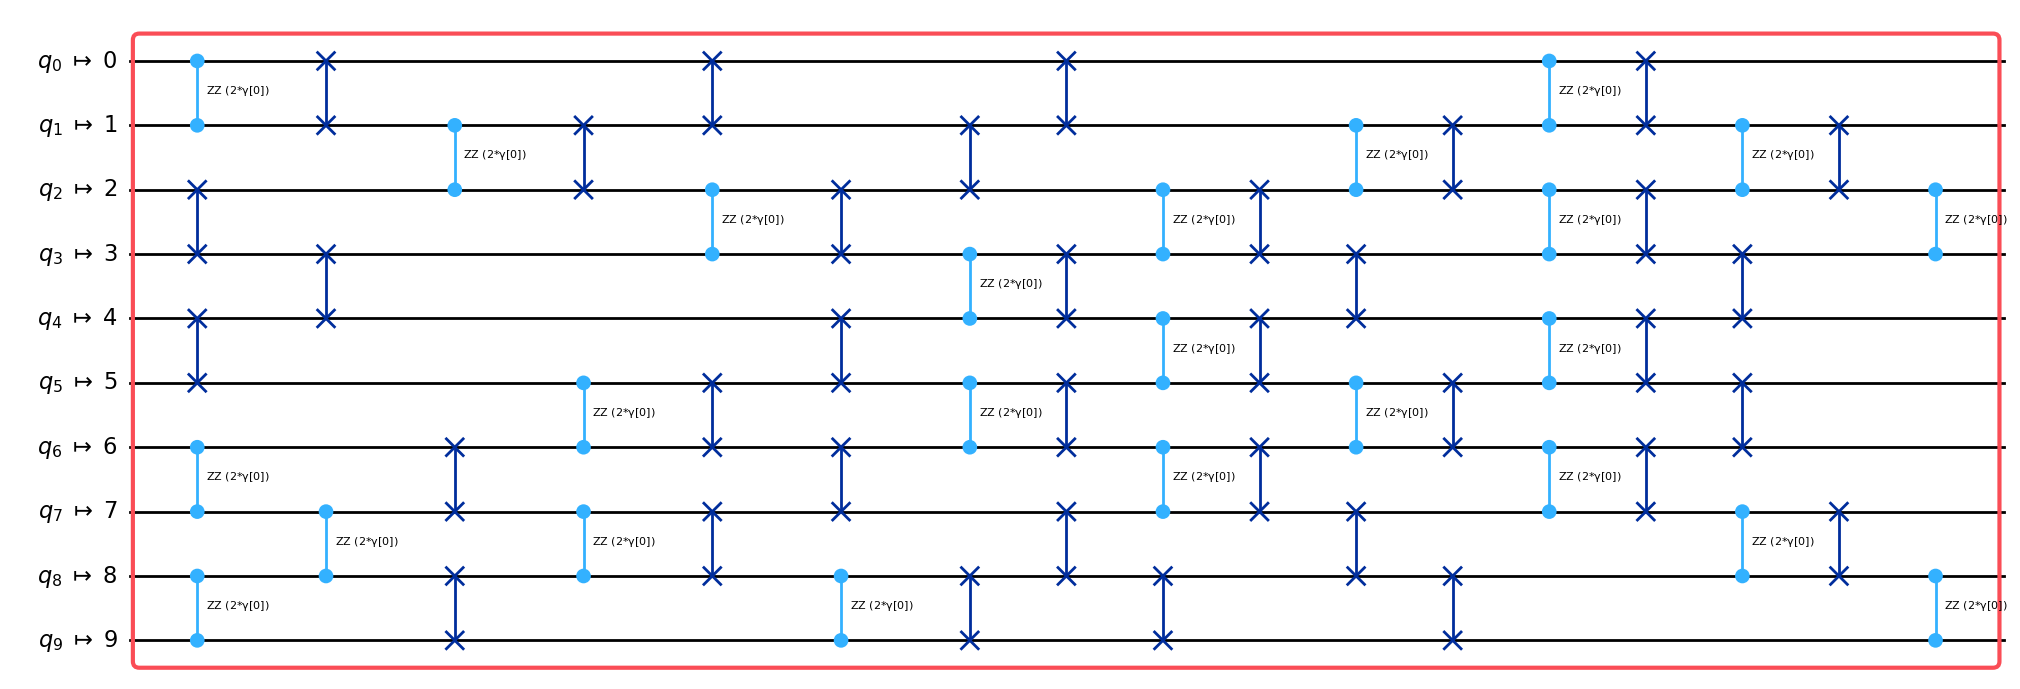

In [8]:
qc1.draw("mpl", fold=-1)

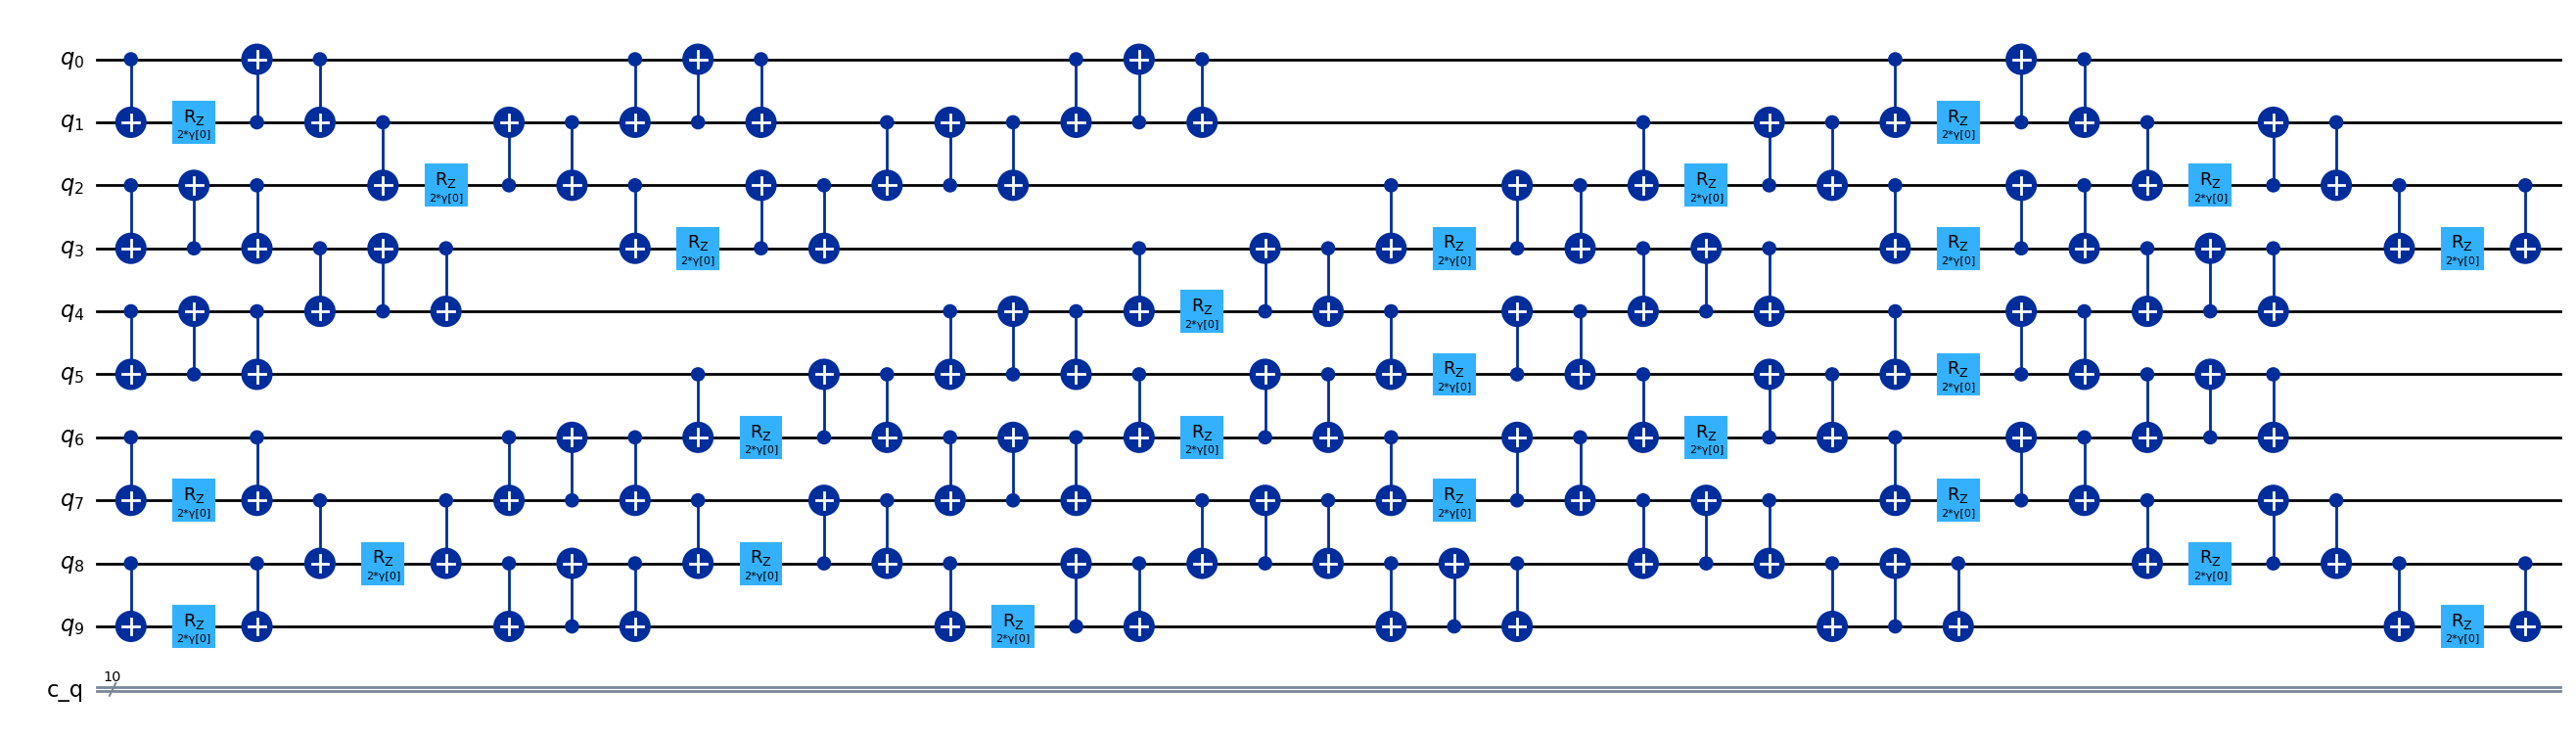

In [9]:
qc2.draw("mpl", fold=-1)

### 1.4. Integrate in Qiskit's preset pass manager

In [10]:
from qiskit.transpiler import generate_preset_pass_manager
from qopt_best_practices.transpilation import *

pre_init = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
        AnnotatedSwapToFinalMapping(),
        SynthesizeAndSimplifyCostLayer(basis_gates=["x", "cx", "sx", "rz", "id"]),
        UnrollBoxes(),
    ]
)

pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
pm.pre_init = pre_init

### 1.5. Run complete pass manager on full annotated ansatz

In [11]:
ansatz = annotated_qaoa_ansatz(
    cost_operator,
    reps=2,
)
ansatz.measure_all()
optimized_circ = pm.run(ansatz)

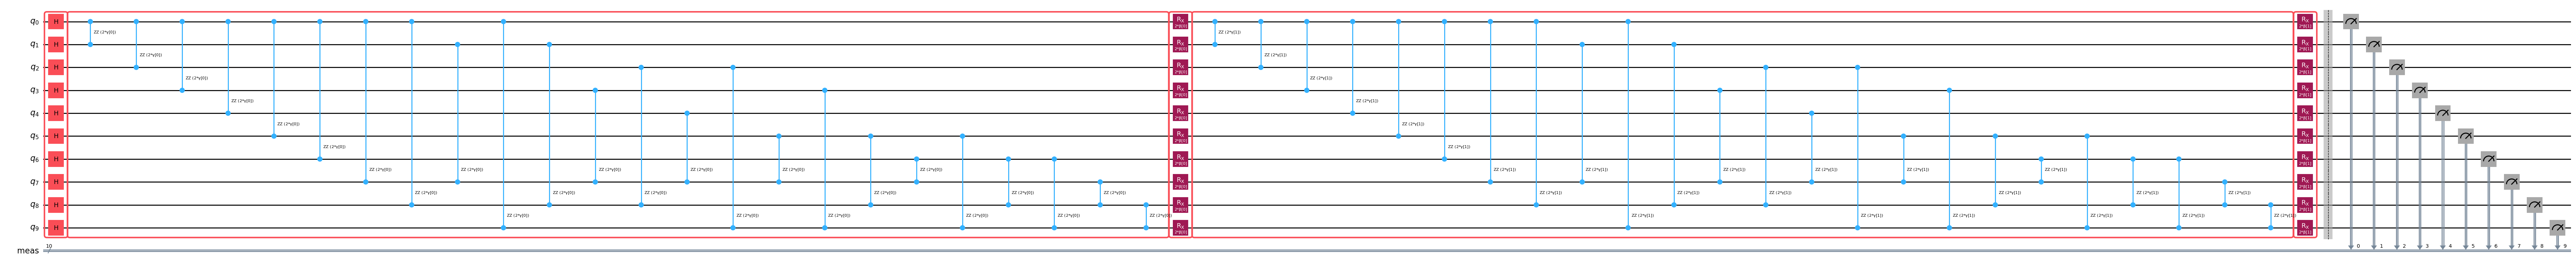

In [12]:
ansatz.draw("mpl", fold=-1)

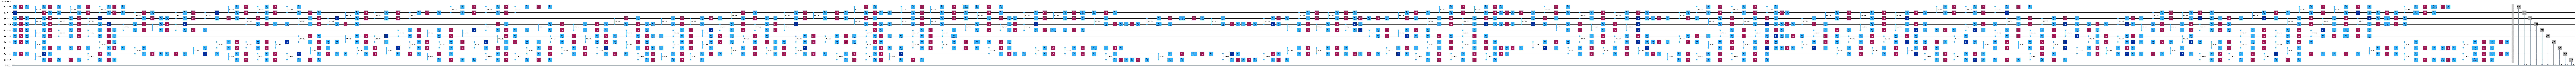

In [13]:
optimized_circ.draw("mpl", fold=-1)

Run default transpilation and compare depth, number of operations with our custom pipeline.

In [14]:
# Run naive transpilation

from qiskit.circuit.library import qaoa_ansatz

ref_ansatz = qaoa_ansatz(cost_operator, reps=2)
ref_ansatz.measure_all()
pm_ref = generate_preset_pass_manager(target=backend.target, optimization_level=3)
ref_optimized = pm.run(ref_ansatz)
ref_optimized.count_ops()

OrderedDict([('rz', 699),
             ('sx', 492),
             ('rzz', 273),
             ('x', 35),
             ('measure', 10),
             ('barrier', 1)])

In [15]:
print(
    f"Depth comparison: default transpilation {ref_optimized.depth()} vs custom transpilation {optimized_circ.depth()}"
)
print(
    f"2-qubit Depth comparison: default transpilation {ref_optimized.depth(filter_function=lambda x: x.operation.num_qubits == 2)} vs custom transpilation {optimized_circ.depth(filter_function=lambda x: x.operation.num_qubits == 2)}"
)

Depth comparison: default transpilation 488 vs custom transpilation 256
2-qubit Depth comparison: default transpilation 145 vs custom transpilation 60


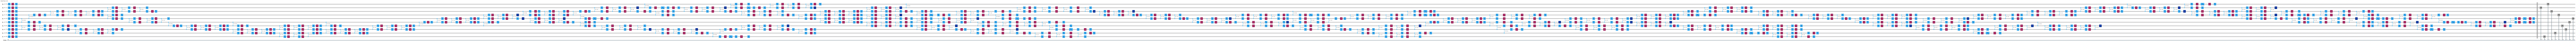

In [16]:
ref_optimized.draw("mpl", fold=-1)

## 2. How to apply SATMapper (in combination with SWAP strategies)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIIIZ', 'IZIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZIIZI', 'IIZIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIZIZII', 'IIIIIIIIIIIIIZIIIZII', 'IIIIIIIIIIIIZIIIZIII', 'IIIIIIIIIIIIIZIIZIII', 'IIIIIIIIZIIIIIIIZIII', 'IIIIIZIIIIIIIIIZIIII', 'IIIIIIIIIIIIZIZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIZIIIIIZIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIZIIZIIIIIII', 'IZIIIIIIIIIZIIIIIIII', 'IIIZIIIIIIIZIIIIIIII', 'ZIIIIIIIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIZIIIIIIZIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIII', 'IIIZIIIZIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IIZIIIZIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIII', 'IZIIZIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j]

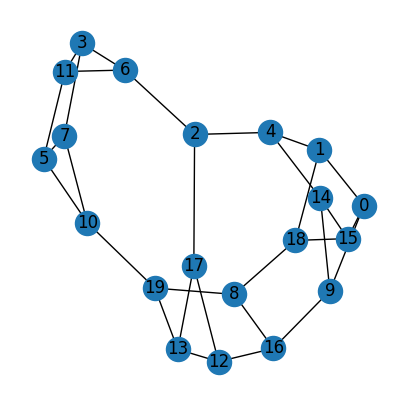

In [17]:
# SETUP: build graph, get cost op, define coupling map and backend

import matplotlib.pyplot as plt
import networkx as nx
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qopt_best_practices.utils import build_max_cut_paulis

graph = nx.random_regular_graph(n=20, d=3, seed=0)

cost_op = SparsePauliOp.from_list(build_max_cut_paulis(graph))
print(cost_op)
cmap = CouplingMap([(idx, idx + 1) for idx in range(graph.order() - 1)])
backend = GenericBackendV2(
    num_qubits=20,
    coupling_map=cmap,
    basis_gates=["x", "sx", "rzz", "id", "rz"],
    seed=0,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nx.draw(graph, with_labels=True, ax=ax)

In [18]:
# SETUP: build custom pass manager with SWAP strategies

from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation import (
    AnnotatedPrepareCostLayer,
    AnnotatedCommuting2qGateRouter,
    AnnotatedSwapToFinalMapping,
    UnrollBoxes,
)
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
)

swap_strategy = SwapStrategy.from_line([i for i in range(graph.order())])

pre_init = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy),
        AnnotatedSwapToFinalMapping(),
        UnrollBoxes(),
    ]
)

### A. Run transpilation WITHOUT SAT mapping

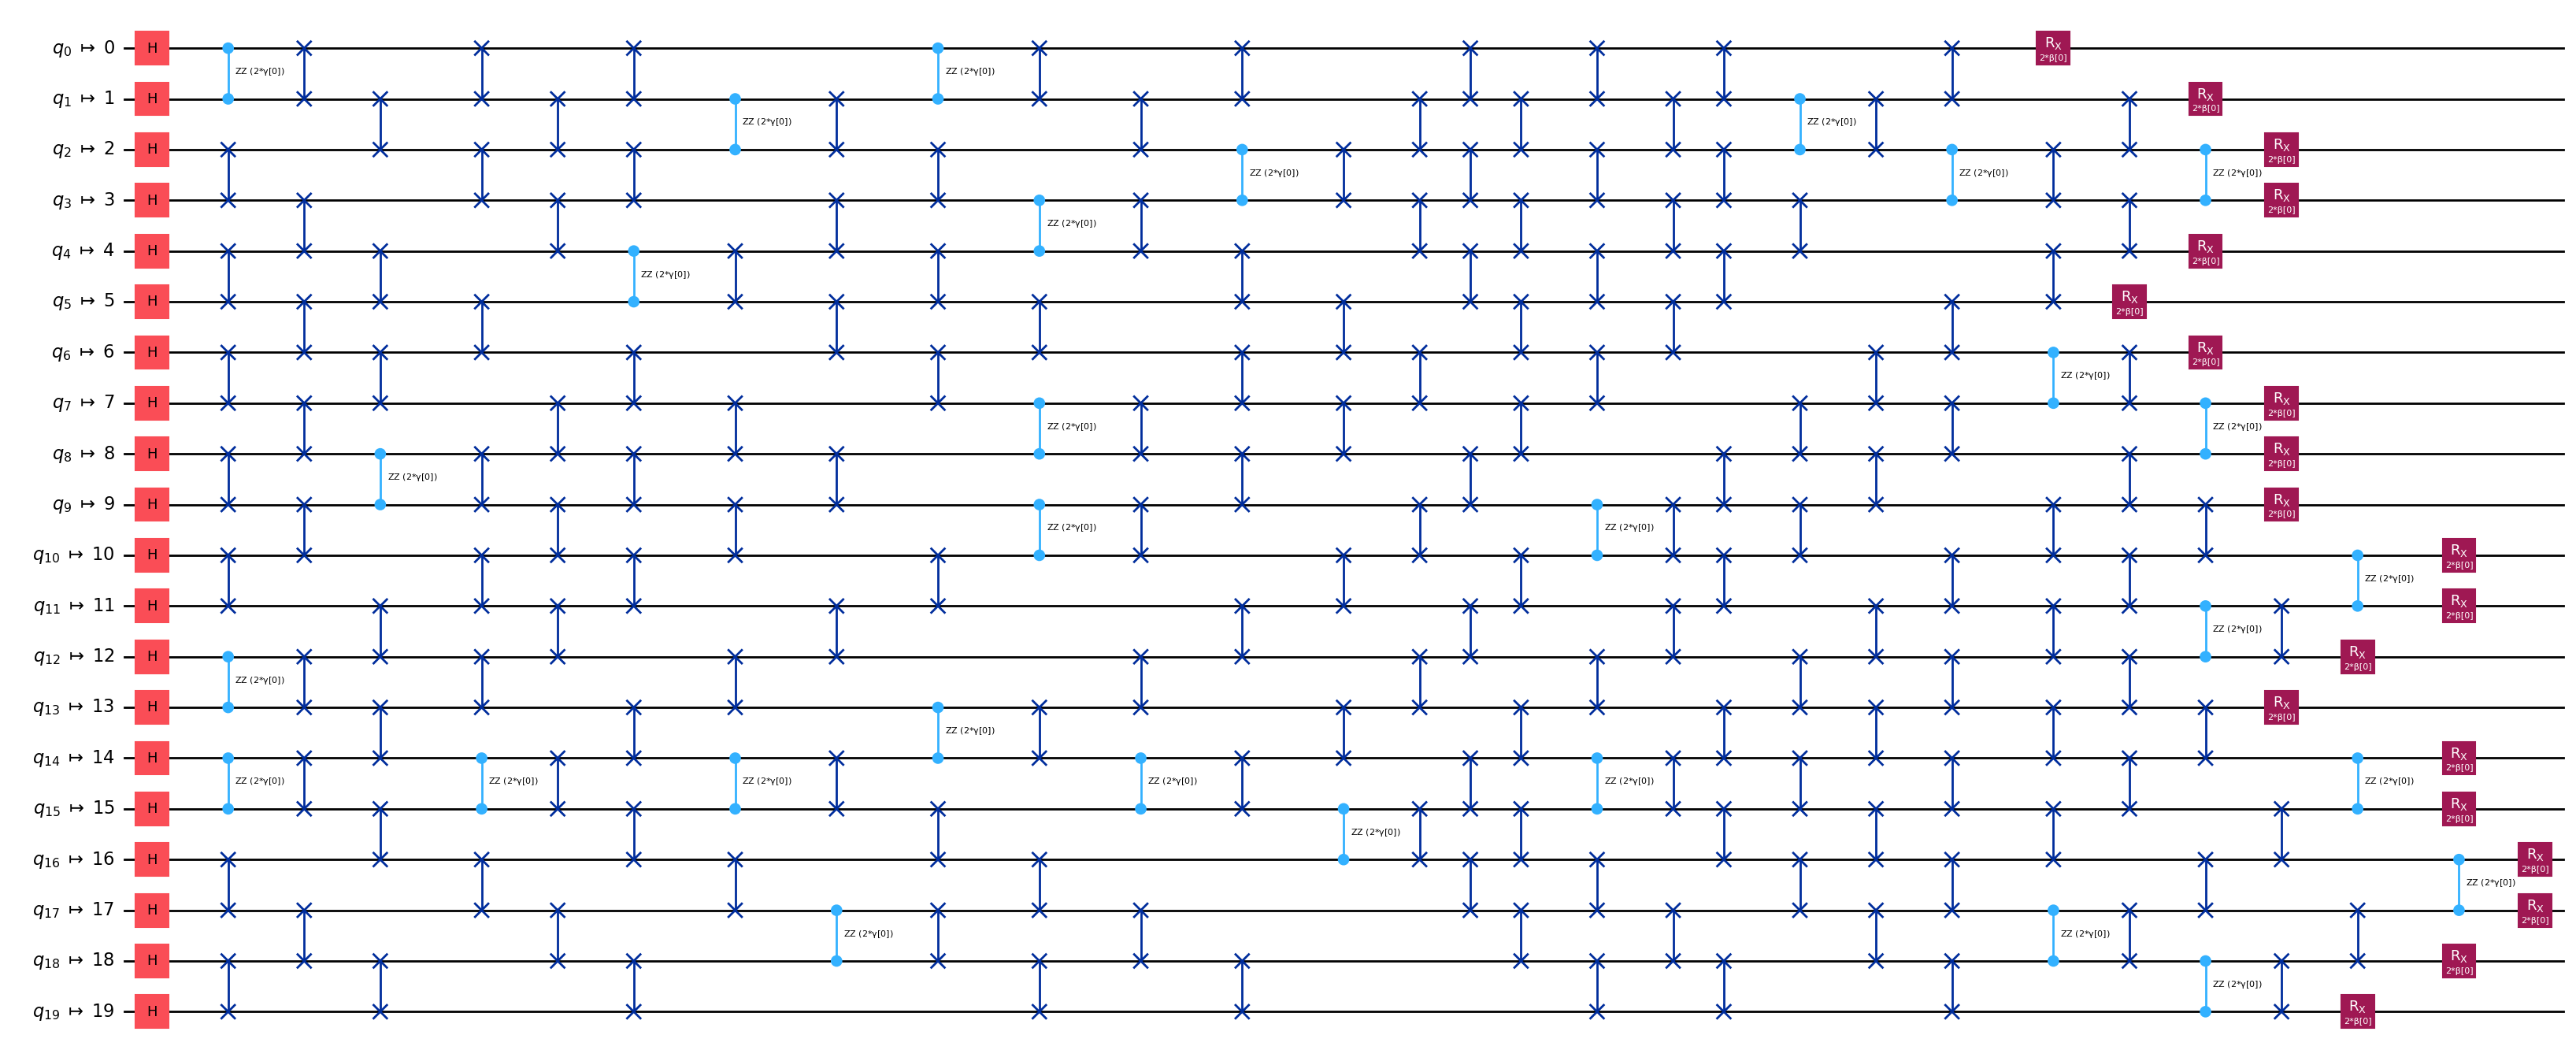

In [19]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

ansatz_no_sat = annotated_qaoa_ansatz(cost_op, reps=1)
transpiled_ansatz_no_sat = pre_init.run(ansatz_no_sat)
transpiled_ansatz_no_sat.draw("mpl", fold=False)

### B. Run same transpilation after applying SAT mapping

Map from old to new edges:  {0: 6, 1: 11, 2: 13, 3: 3, 4: 12, 5: 0, 6: 2, 7: 1, 8: 9, 9: 17, 10: 7, 11: 5, 12: 18, 13: 19, 14: 16, 15: 15, 16: 10, 17: 14, 18: 4, 19: 8}
Min SAT layers: 5


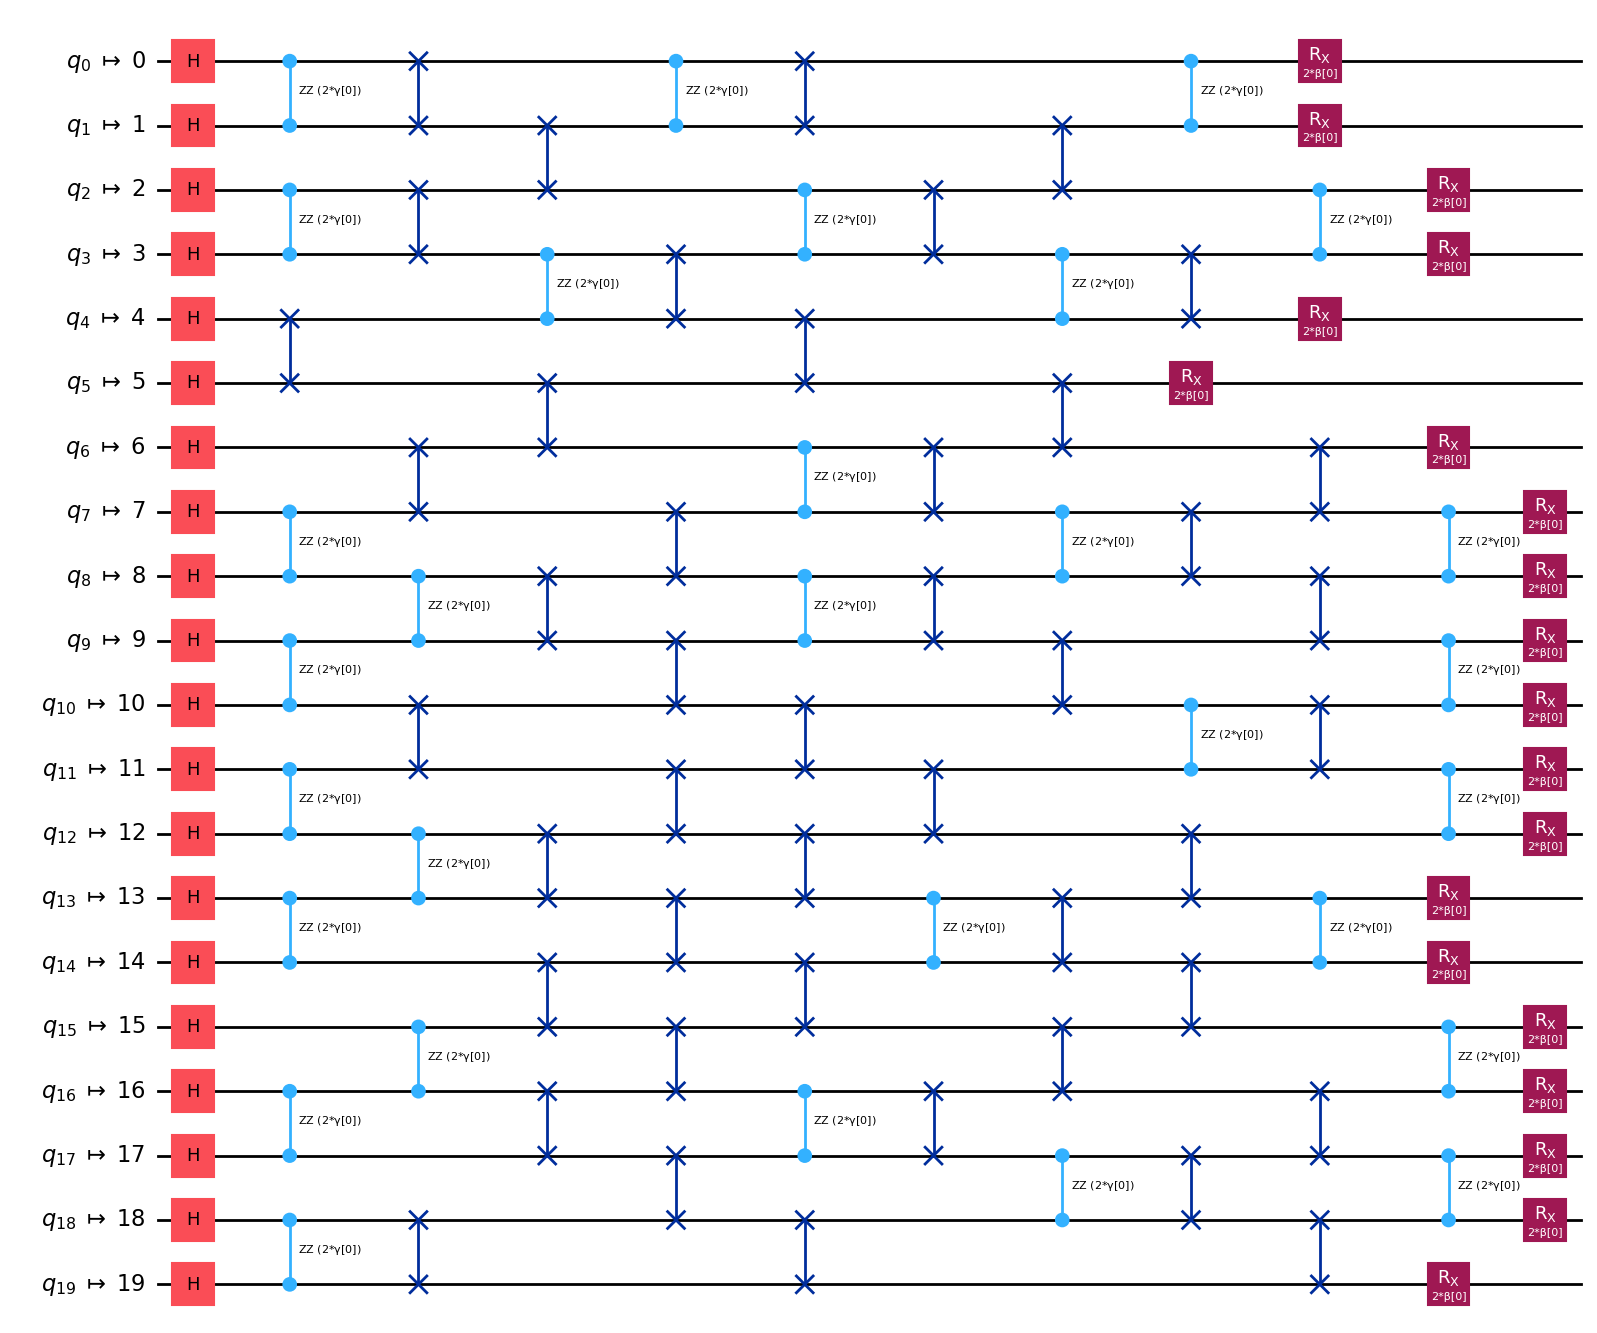

In [20]:
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper(timeout=10)
sat_cost_op, sat_map, min_sat_layers = sm.remap_graph_with_sat(
    graph=cost_op, swap_strategy=swap_strategy
)

print("Map from old to new edges: ", sat_map)
print("Min SAT layers:", min_sat_layers)

ansatz_sat = annotated_qaoa_ansatz(sat_cost_op, reps=1)
transpiled_ansatz_sat = pre_init.run(ansatz_sat)
transpiled_ansatz_sat.draw("mpl", fold=False)

Compare number of operations, depth and 2-qubit depth:

In [21]:
print(transpiled_ansatz_sat.count_ops())
print(transpiled_ansatz_sat.depth())
print(
    transpiled_ansatz_sat.depth(filter_function=lambda x: x.operation.num_qubits == 2)
)

print(transpiled_ansatz_no_sat.count_ops())
print(transpiled_ansatz_no_sat.depth())
print(
    transpiled_ansatz_no_sat.depth(
        filter_function=lambda x: x.operation.num_qubits == 2
    )
)

OrderedDict([('swap', 45), ('rzz', 30), ('h', 20), ('rx', 20)])
12
10
OrderedDict([('swap', 169), ('rzz', 30), ('h', 20), ('rx', 20)])
30
28
